In [214]:
import numpy as np
import pandas as pd
import random
import xgboost as xgb

from dtreeviz.trees import *
from sklearn.datasets import load_breast_cancer, load_iris, load_diabetes
from sklearn.model_selection import train_test_split

In [2]:
seed = 444

random.seed(seed)
np.random.seed(seed)

# 二分类

In [114]:
cancer = load_breast_cancer()
feature_names = cancer.feature_names.tolist()
class_names = cancer.target_names.tolist()
X = cancer.data
Y = cancer.target
test_ratio = 0.2


print(X.shape, Y.shape)

(569, 30) (569,)


In [115]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_ratio, random_state=seed)

In [116]:
dtrain = xgb.DMatrix(x_train, y_train, feature_names=cancer.feature_names)
dtest = xgb.DMatrix(x_test[:10], y_test[:10], feature_names=cancer.feature_names)

In [117]:
params = {
    "objective": "binary:logistic",
    "booster": "gbtree", 
    "max_depth": 3, 
}
num_estimators = 3
watch_list = [(dtrain, "train"), (dtest, "eval")]

In [118]:
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_estimators, evals=watch_list)

[17:05:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.46400	eval-logloss:0.44367
[1]	train-logloss:0.33392	eval-logloss:0.30305
[2]	train-logloss:0.25276	eval-logloss:0.22352


## 关于模型预测

In [119]:
pred = model.predict(dtest)
pred

array([0.25689885, 0.80514336, 0.80514336, 0.80514336, 0.80514336,
       0.19154955, 0.80514336, 0.19154955, 0.80514336, 0.19154955],
      dtype=float32)

In [121]:
# 模型原始的输出值 --- 转化为概率之前的值
ypred_margin = model.predict(dtest, output_margin=True)  # , iteration_range=(0,1))
ypred_margin

array([-1.0621498,  1.4187561,  1.4187561,  1.4187561,  1.4187561,
       -1.4399728,  1.4187561, -1.4399728,  1.4187561, -1.4399728],
      dtype=float32)

In [122]:
# 将 ypred_margin 输入到 sigmoid 中，得到每个样本属于 1 的概率 
1 / (1 + np.exp(-ypred_margin))

array([0.25689885, 0.80514336, 0.80514336, 0.80514336, 0.80514336,
       0.19154955, 0.80514336, 0.19154955, 0.80514336, 0.19154955],
      dtype=float32)

In [123]:
model.predict(dtest, pred_contribs=1).sum(axis=1)

array([-1.0621498,  1.418756 ,  1.418756 ,  1.4187561,  1.418756 ,
       -1.4399726,  1.4187561, -1.4399726,  1.418756 , -1.4399728],
      dtype=float32)

In [124]:
# 原始输出值所在的叶子节点下标
ypred_leaf = model.predict(dtest, pred_leaf=True)
ypred_leaf

array([[12., 14.,  9.],
       [ 7.,  7.,  7.],
       [ 7.,  7.,  7.],
       [ 7.,  7.,  7.],
       [ 7.,  7.,  7.],
       [12., 14., 10.],
       [ 7.,  7.,  7.],
       [12., 14., 10.],
       [ 7.,  7.,  7.],
       [12., 14., 10.]], dtype=float32)

## 关于模型可视化

In [125]:
model.dump_model("breast_cancer_binary_logistic.txt")

<AxesSubplot:>

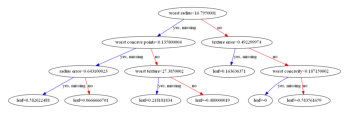

In [126]:
xgb.plot_tree(model, rounded=True)  # feature_names=data.feature_names.tolist(), class_names=data.target_names.tolist(),  filled=True

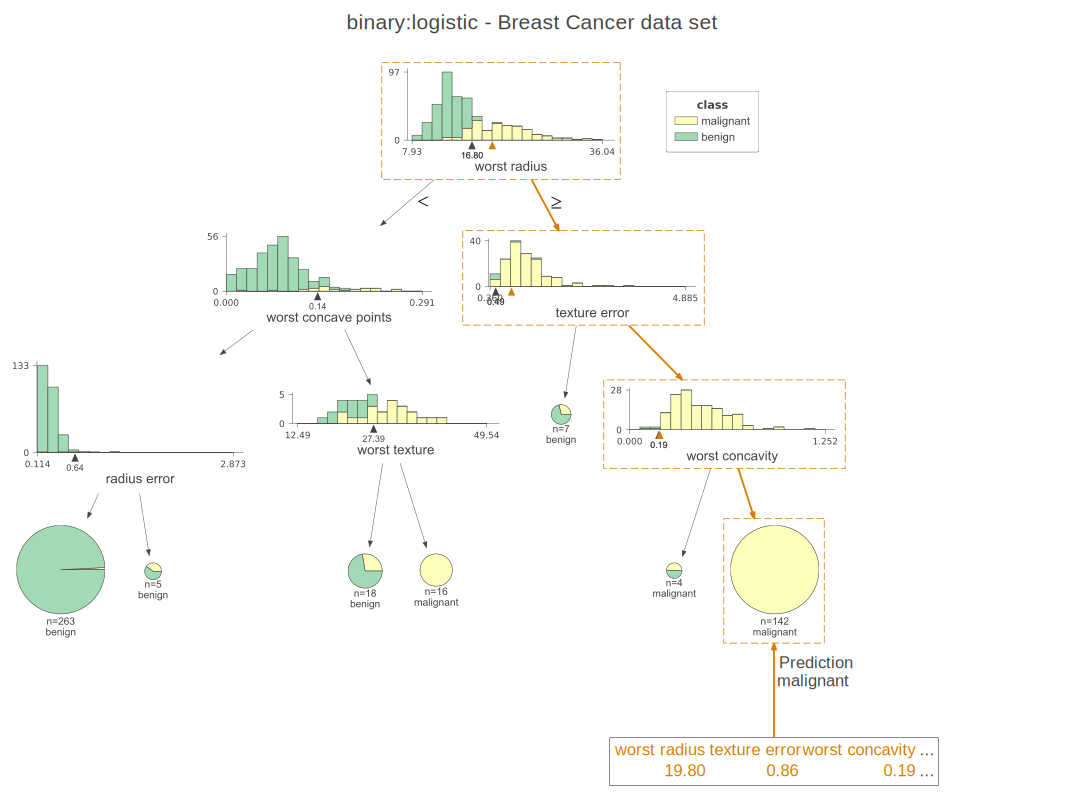

In [128]:
viz = dtreeviz(model, 
               tree_index=0,
               x_data=x_train,
               y_data=y_train,
               X=x_test[0],  # 可视化有一个样本的分类过程
#                show_just_path=1,  # 是否只展示预测过程
               fancy=1,  # 是否进行美化
               target_name='class',
               feature_names=feature_names, 
               class_names=class_names, 
               title="binary:logistic - Breast Cancer data set",
               scale=1.5)
viz

In [100]:
model.get_fscore()

{'mean concave points': 1.0,
 'radius error': 1.0,
 'texture error': 1.0,
 'area error': 1.0,
 'worst radius': 3.0,
 'worst texture': 4.0,
 'worst perimeter': 1.0,
 'worst concavity': 2.0,
 'worst concave points': 4.0}

## 总结

关于参数的一些解释：
- `binary:logistic`: 这个表示目标函数使用的是逻辑回归中常用的损失函数 cross-entropy 损失函数。因此，对于每一棵树，**其实每个叶子节点的值是逻辑回归中的** $\theta * x$；
- `num_boost_round`: 即提升的次数，对于基学习器为树时，就是决策树的数量，对于线性模型（如 `gblinear`）就等同于 epoch，即在数据集上迭代的次数；

关于预测的一些解释：
- model.predict(dtest): 输出的是每个样本属于 1 的概率值；
- model.predict(dtest, pred_leaf=1): 输出的值一个矩阵，形状是 (n_samples, n_trees)，每一行表示一个样本的预测结果 --- 分别落在了树中的哪个节点上。可以用来构造交叉特征。；
- model.predict(dtest, output_margin=1): 输出的是每个样本的回归值，即 $\theta * x$，即在进入 `sigmoid` 函数之前的值；
- model.predict(dtest, pred_contribs=1): 输出的值是一个矩阵，形状是 (n_samples, n_features+1)，每一行的含义：样本的每一个特征对预测值的贡献，最后一个表示 bias 的贡献。每一行的和即为 margin 值；
- iteration_range: 指的是迭代轮数的范围，在二分类中等同于树的范围，但是**在多分类中则不然** --- 只表示迭代轮数的范围。

**每棵树都是对训练集的一次划分！**

# 多分类

In [152]:
iris = load_iris()
feature_names = iris.feature_names  #.tolist()
class_names = iris.target_names.tolist()
X = iris.data
Y = iris.target
test_ratio = 0.2


print(X.shape, Y.shape)

(150, 4) (150,)


In [153]:
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [154]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_ratio, random_state=seed)

In [156]:
dtrain = xgb.DMatrix(x_train, y_train, feature_names=iris.feature_names)
dtest = xgb.DMatrix(x_test, y_test, feature_names=iris.feature_names)

In [179]:
params = {
    "objective": "multi:softmax",
    "booster": "gbtree", 
    "num_class": len(class_names),
    "max_depth": 3, 
}
num_estimators = 2
watch_list = [(dtrain, "train"), (dtest, "eval")]

In [181]:
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_estimators, evals=watch_list)

[16:43:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:0.73627	eval-mlogloss:0.77685
[1]	train-mlogloss:0.52473	eval-mlogloss:0.59459


## 关于模型预测

In [182]:
pred = model.predict(dtest)
pred

array([1., 2., 1., 2., 0., 1., 1., 0., 2., 0., 2., 0., 1., 1., 2., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 2., 0., 2., 1., 2.], dtype=float32)

In [213]:
pred_margin = model.predict(dtest.slice(range(2)), output_margin=1, iteration_range=(0,1))
pred_margin

array([[0.281155  , 0.464     , 0.28172755],
       [0.281155  , 0.28823525, 0.92484474]], dtype=float32)

In [205]:
pred_leaf = model.predict(dtest.slice(range(2)), iteration_range=(0,1), pred_leaf=1)
pred_leaf

array([[2., 6., 3.],
       [2., 8., 6.]], dtype=float32)

In [209]:
t = np.array([-0.218845025, -0.0360000096, -0.218272462])
t2 = ([-0.195637301, -0.0309270918, -0.19463484])
np.exp(t) / np.exp(t).sum(), np.exp(t2) / np.exp(t2).sum(), np.exp(t+t2) / np.exp(t+t2).sum()

(array([0.31238275, 0.37505558, 0.31256166]),
 array([0.31446003, 0.37076454, 0.31477543]),
 array([0.29263907, 0.41426059, 0.29310034]))

## 关于模型

In [186]:
model.dump_model("iris_multi_softmax.txt")

In [189]:
x_train.shape

(120, 4)

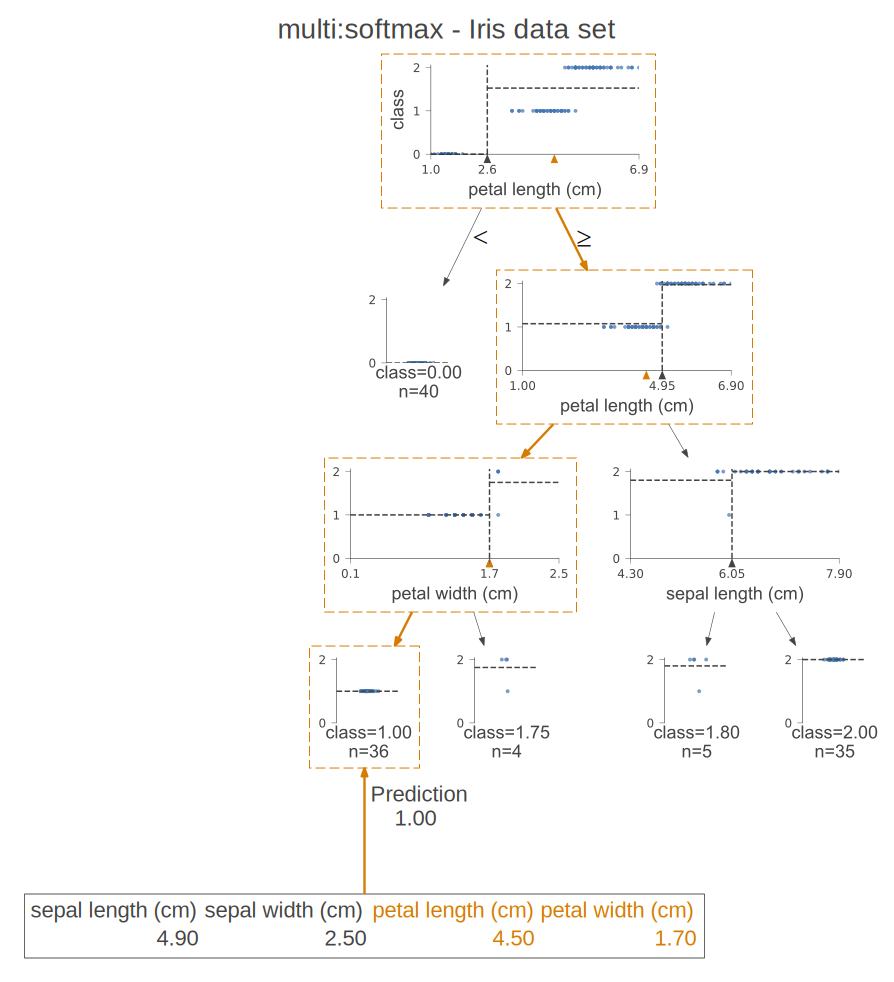

In [200]:
viz = dtreeviz(model, 
               tree_index=4,
               x_data=x_train,
               y_data=y_train,
               X=x_test[0],  # 可视化有一个样本的分类过程
#                show_just_path=1,  # 是否只展示预测过程
               fancy=1,  # 是否进行美化
               target_name='class',
               feature_names=feature_names, 
               class_names=[0,1,2],  #class_names, 
               title=f"{params['objective']} - Iris data set",
               scale=2)
viz

## 总结

在多分类的训练过程中，`num_boost_round` 指定了提升的轮数，在每一轮提升中，会学习出 `num_class` 棵树。
在训练过程中，树的生成顺序是： `类别1的第1棵树、类别2的第1棵树、类别c的第1棵树、...、类别1的第n棵树、...、类别c的第n棵树`，即每一轮学习 `num_class` 棵树。

关于参数的一些解释：
- 'multi:softmax': 设置 `softmax` 作为多分类的损失函数，需要制定类别的个数 `num_class`；
- 'iteration_range': 在预测时，用于指定使用哪一轮训练的模型进行预测，在多分类中

关于预测的一些解释：
- pred_leaf: 输出的是矩阵，形状是 (n_samples, num_class * num_boost_round)；

但是还有一个问题：`给定一个样本，使用训练好的模型进行预测，样本会在每棵树的叶子结点上得到一个分数，这个分数是如何转化成样本属于不同类别的概率的呢？`

# 回归

In [218]:
diabetes = load_diabetes()
feature_names = diabetes.feature_names
# class_names = diabetes.target_names
X = diabetes.data
Y = diabetes.target
test_ratio = 0.2


print(X.shape, Y.shape)

(442, 10) (442,)


In [219]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_ratio, random_state=seed)

In [221]:
dtrain = xgb.DMatrix(x_train, y_train, feature_names=feature_names)
dtest = xgb.DMatrix(x_test, y_test, feature_names=feature_names)

In [224]:
params = {
    "objective": "reg:squarederror",
    "booster": "gbtree", 
    "max_depth": 3, 
}
num_estimators = 2
watch_list = [(dtrain, "train"), (dtest, "eval")]

In [225]:
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_estimators, evals=watch_list)

[0]	train-rmse:126.74273	eval-rmse:121.77408
[1]	train-rmse:97.12580	eval-rmse:92.91832


## 关于模型预测

In [244]:
pred = model.predict(dtest.slice(range(2)))
pred

array([106.27969 , 124.411964], dtype=float32)

In [234]:
pred_margin = model.predict(dtest.slice(range(2)), output_margin=1, iteration_range=(0,2))
pred_margin

array([106.27969 , 124.411964], dtype=float32)

In [231]:
pred_leaf = model.predict(dtest.slice(range(2)), iteration_range=(0,2), pred_leaf=1)
pred_leaf

array([[14., 12.],
       [14., 13.]], dtype=float32)

## 关于模型

In [229]:
model.dump_model("diabetes_reg_squarederror.txt")

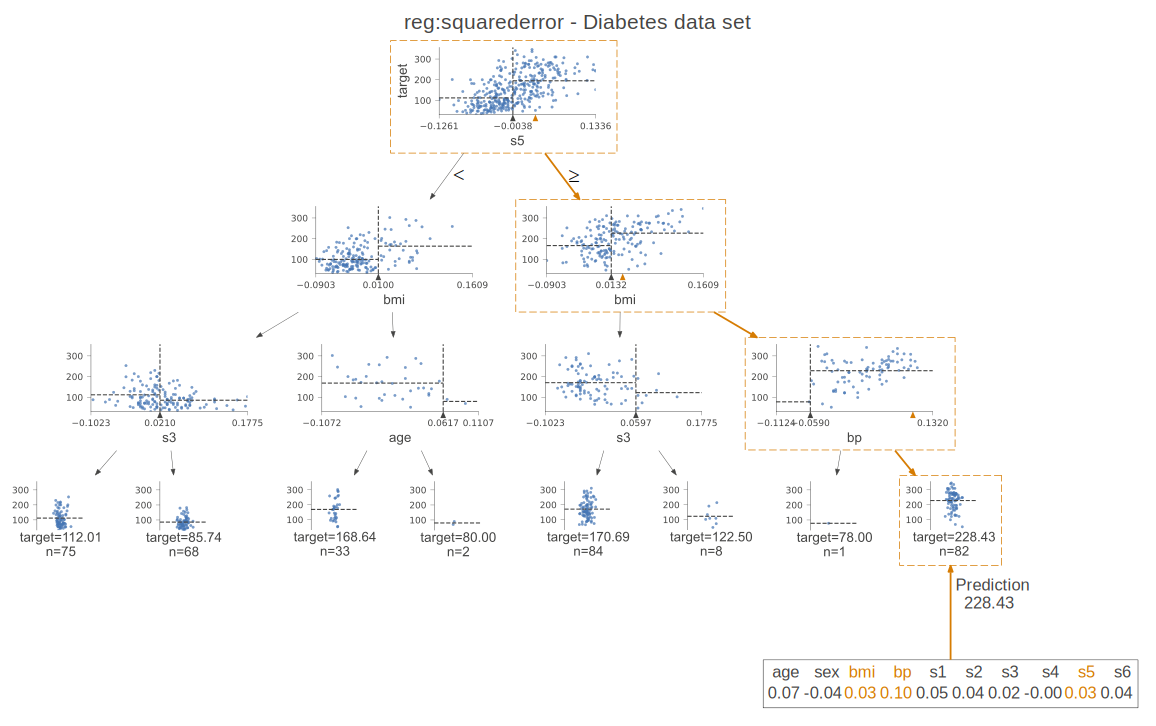

In [248]:
viz = dtreeviz(model, 
               tree_index=0,
               x_data=x_train,
               y_data=y_train,
               X=x_test[0],  # 可视化有一个样本的分类过程
#                show_just_path=1,  # 是否只展示预测过程
               fancy=1,  # 是否进行美化
               target_name='target',
               feature_names=feature_names, 
#                class_names=[0,1,2],  #class_names, 
               title=f"{params['objective']} - Diabetes data set",
               scale=1.5)
viz

## 总结

回归中，样本所对应的叶子节点的分数求和即是输出的预测值。

# categorical data

**什么是类别特征？**
>类别特征指离散的，特征的取值数量是可数的。在现有的大多数算法中，计算相似性是一个很重要的问题，但是类别特征不一定可以计算相似性。在连续特征的特征空间中，样本点之间的相似性是可以通过距离来衡量的，而距离又是通过特征值计算出来的，这里的计算主要发生在欧氏空间中。但是离散特征之间的计算并不像欧氏空间那么简单，有些类别特征之间不具有可比性，如 `城市` 这个特征，但是有些类别特征又是可以比较的，例如年龄。因此，对于不同的类别特征是有不同的处理方法的，对于那些不能比较的，可以转化成 one-hot，或者用 embedding 来代替。

因为 xgboost 中的树是回归树，主要用于预测回归值，即使在二分类中，预测的也是回归值，只是这个回归值是在对数几率。因此，xgboost 一开始是不支持类别特征的，但是在后续的版本中加入了对类别特征的支持。

在 xgboost 中，可以直接传入类别特征或者转成 one-hot 编码。如果输入的数据是 pd.DataFrame 格式，则可以设置特征的类型：`.astype("category")`，如果使用 `xgb.DMatrix`，则可以传入特征的类型：`feature_types=['q','c', ...]`，`q` 表示为实值类型的特征，`c` 表示 category。

In [270]:
from typing import Tuple

def make_categorical(
    n_samples: int, n_features: int, n_categories: int, onehot: bool
) -> Tuple[pd.DataFrame, pd.Series]:
    """Make some random data for demo."""
    rng = np.random.RandomState(1994)

    pd_dict = {}
    for i in range(n_features + 1):
        c = rng.randint(low=0, high=n_categories, size=n_samples)
        pd_dict[str(i)] = pd.Series(c, dtype=np.int64)

    df = pd.DataFrame(pd_dict)
    label = df.iloc[:, 0]
    df = df.iloc[:, 1:]
    for i in range(0, n_features):
        label += df.iloc[:, i]
    label += 1

    df = df.astype("category")
    categories = np.arange(0, n_categories)
    for col in df.columns:
        df[col] = df[col].cat.set_categories(categories)

    if onehot:
        return pd.get_dummies(df), label
    return df, label


def main() -> None:
    # Use builtin categorical data support
    # For scikit-learn interface, the input data must be pandas DataFrame or cudf
    # DataFrame with categorical features
    print("Pass categorical data")
    X, y = make_categorical(100, 10, 4, False)
    # Specify `enable_categorical` to True, also we use onehot encoding based split
    # here for demonstration. For details see the document of `max_cat_to_onehot`.
    reg = xgb.XGBRegressor(
        tree_method="gpu_hist", enable_categorical=True, max_cat_to_onehot=5, n_estimators=10
    )
    reg.fit(X, y, eval_set=[(X, y)])
    
    print("\nPass in already encoded data")

    # Pass in already encoded data
    X_enc, y_enc = make_categorical(100, 10, 4, True)
    reg_enc = xgb.XGBRegressor(
        tree_method="gpu_hist", n_estimators=10
    )
    reg_enc.fit(X_enc, y_enc, eval_set=[(X_enc, y_enc)])

    reg_results = np.array(reg.evals_result()["validation_0"]["rmse"])
    reg_enc_results = np.array(reg_enc.evals_result()["validation_0"]["rmse"])

    # Check that they have same results
    np.testing.assert_allclose(reg_results, reg_enc_results)

    # Convert to DMatrix for SHAP value
    booster: xgb.Booster = reg.get_booster()
    m = xgb.DMatrix(X, enable_categorical=True)  # specify categorical data support.
    SHAP = booster.predict(m, pred_contribs=True)
    margin = booster.predict(m, output_margin=True)
    np.testing.assert_allclose(
        np.sum(SHAP, axis=len(SHAP.shape) - 1), margin, rtol=1e-3
    )



In [271]:
main()

Pass categorical data
[14:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_cat_to_onehot" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:12.52557
[1]	validation_0-rmse:9.11916
[2]	validation_0-rmse:6.73295
[3]	validation_0-rmse:5.02296
[4]	validation_0-rmse:3.80238
[5]	validation_0-rmse:2.92601
[6]	validation_0-rmse:2.27140
[7]	validation_0-rmse:1.76577
[8]	validation_0-rmse:1.40309
[9]	validation_0-rmse:1.10517

Pass in already encoded data
[0]	validation_0-rmse:12.52557
[1]	validation_0-rmse:9.11916
[2]	validation_0-rmse:6.73295
[3]	validation_0-rmse:5.02296
[4]	validation_0-rmse:3.80238
[5]	validation_0-rmse:2.92601
[6]	validation_0-rmse:2.27140
[7]	valida